<a href="https://colab.research.google.com/github/mandalanil/Portfolio/blob/main/Precp_Nepal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [24]:
# @title Assignment:-3 SSH Forecasting (RNN, LSTM, Transformer)

# ===================================
# 1. SETUP AND IMPORTS
# ===================================
!pip install netCDF4  # <-- ADD THIS LINE

import scipy.io
import numpy as np
import netCDF4
import matplotlib.pyplot as plt
import time
from IPython.display import display, Markdown, HTML
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from numpy.linalg import svd
import matplotlib.animation as animation
import os
import math
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Suppress warnings
import warnings
warnings.filterwarnings("ignore")



--- Task 1: Loading and Exploring Data ---
Mounted at /content/drive
--- NetCDF File 1 Info ---
Variables in file 1: dict_keys(['pr', 'time', 'x', 'y', 'spatial_ref'])
Shape of data from file 1: (336, 93, 182)

--- NetCDF File 2 Info ---
Variables in file 2: dict_keys(['pr', 'time', 'x', 'y', 'spatial_ref'])
Shape of data from file 2: (276, 93, 182)

Spatial dimensions match. Proceeding with merge...

Data from both files merged successfully.
Final merged data shape (time, latitude, longitude): (612, 93, 182)

Visualizing Precipitation maps and time series...


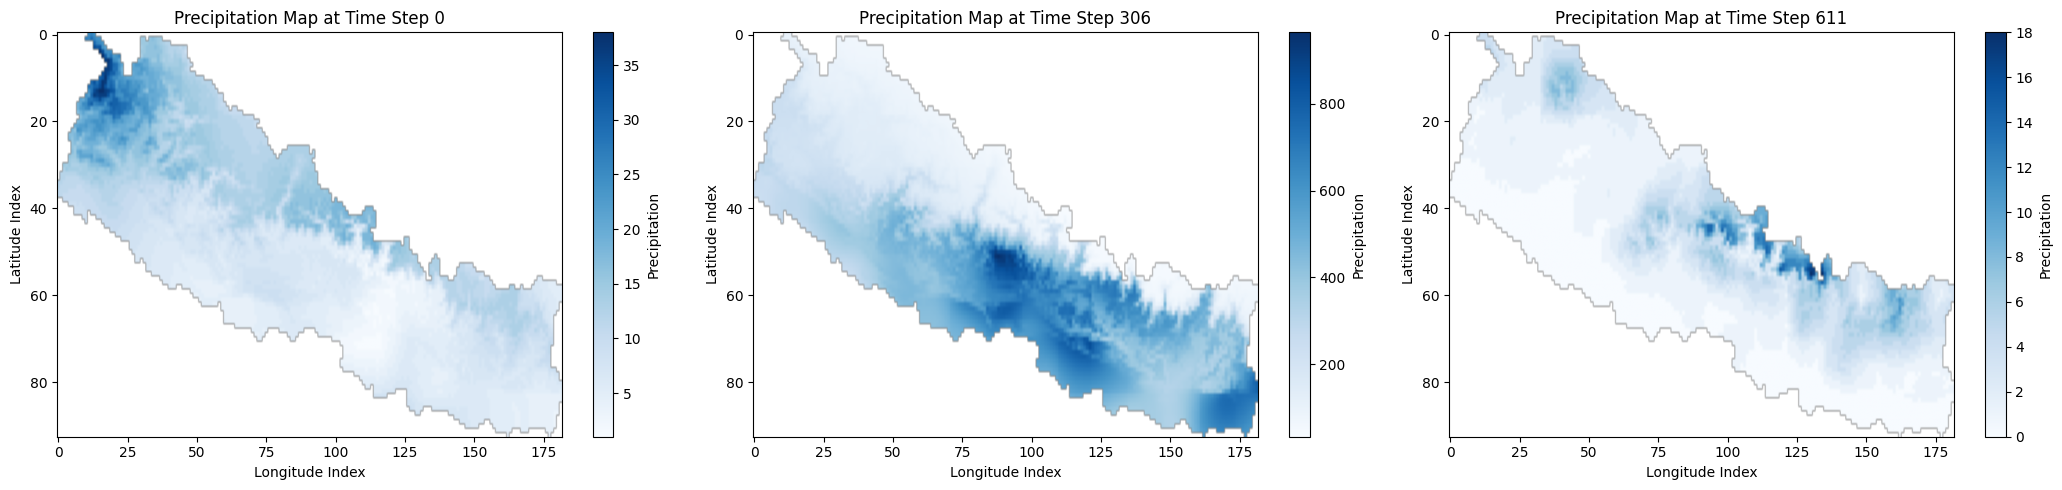

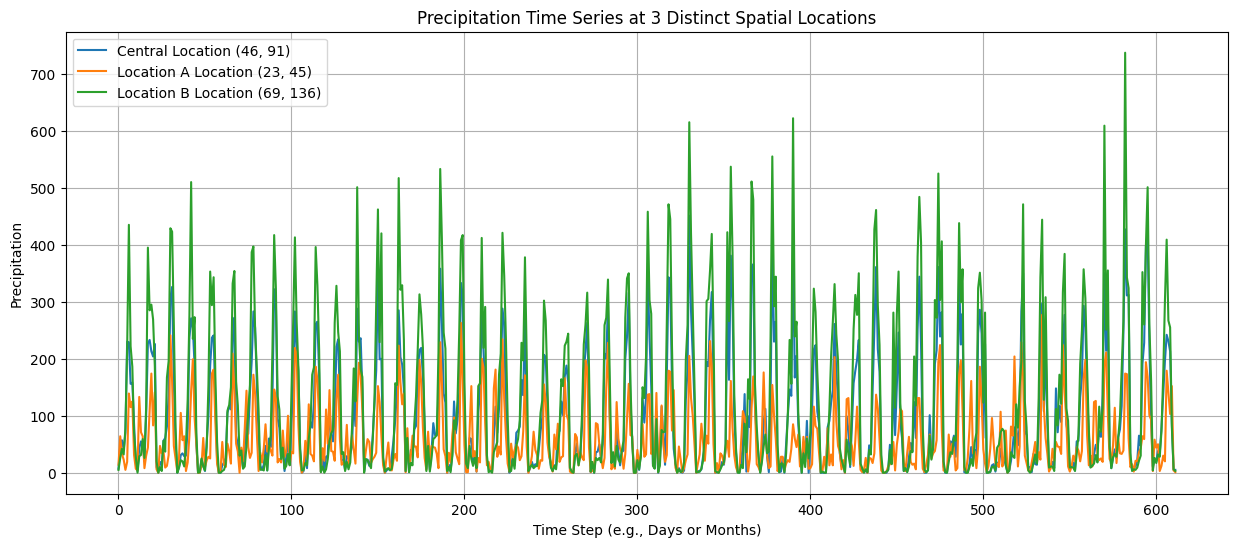

In [25]:
# ===================================
# 2. DATA LOADING & EXPLORATION (Robust version for merging)
# ===================================
print("\n--- Task 1: Loading and Exploring Data ---")

# --- MOUNT GOOGLE DRIVE ---
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# --- NEW: CODE TO MERGE AND LOAD MULTIPLE .NC FILES ---
import netCDF4 as nc
import numpy as np
import matplotlib.pyplot as plt

# --- IMPORTANT: UPDATE THESE THREE LINES TO MATCH YOUR FILES ---
NC_FILE_PATH_1 = '/content/drive/MyDrive/ClimateNepal/data/Precp_1972-1999.nc'
NC_FILE_PATH_2 = '/content/drive/MyDrive/ClimateNepal/data/Precp_2000-2022.nc'
VARIABLE_NAME = 'pr'

try:
    # --- Load the first NetCDF file ---
    with nc.Dataset(NC_FILE_PATH_1, 'r') as nc_data1:
        print("--- NetCDF File 1 Info ---")
        print("Variables in file 1:", nc_data1.variables.keys())
        data1 = nc_data1.variables[VARIABLE_NAME][:]
        print(f"Shape of data from file 1: {data1.shape}")

    # --- Load the second NetCDF file ---
    with nc.Dataset(NC_FILE_PATH_2, 'r') as nc_data2:
        print("\n--- NetCDF File 2 Info ---")
        print("Variables in file 2:", nc_data2.variables.keys())
        data2 = nc_data2.variables[VARIABLE_NAME][:]
        print(f"Shape of data from file 2: {data2.shape}")

    # --- VALIDATION CHECK: Ensure spatial dimensions match before merging ---
    if data1.shape[1:] != data2.shape[1:]:
        print("\n\nERROR: The spatial dimensions (latitude, longitude) of the two files do not match.")
        print(f"Shape of File 1 (lat, lon): {data1.shape[1:]}")
        print(f"Shape of File 2 (lat, lon): {data2.shape[1:]}")
        print("Cannot concatenate. Please ensure the grids are identical.")
        # Stop execution if shapes don't match
        raise ValueError("Spatial dimensions mismatch between NetCDF files.")
    else:
        print("\nSpatial dimensions match. Proceeding with merge...")


    # --- MERGE THE DATA ALONG THE TIME AXIS (axis=0) ---
    data_3d = np.concatenate((data1, data2), axis=0)

except FileNotFoundError as e:
    print(f"\n\nERROR: A file was not found. Please double-check your file paths in the code.")
    print(e)
    raise
except KeyError:
    print(f"\n\nERROR: Variable '{VARIABLE_NAME}' not found in one of the NetCDF files.")
    raise
except Exception as e:
    print(f"\n\nAn unexpected error occurred: {e}")
    raise


# --- The rest of your code should work as before ---
n_time, n_lat, n_lon = data_3d.shape
print(f"\nData from both files merged successfully.")
print(f"Final merged data shape (time, latitude, longitude): {data_3d.shape}")


# --- Visualize Precipitation Data  ---
# (This part of your code remains unchanged)
print("\nVisualizing Precipitation maps and time series...")
fig, axes = plt.subplots(1, 3, figsize=(21, 5))
time_steps_to_plot = [0, n_time // 2, n_time - 1]
for i, t in enumerate(time_steps_to_plot):
    ax = axes[i]
    im = ax.imshow(data_3d[t], cmap='Blues', aspect='auto')
    ax.set_title(f"Precipitation Map at Time Step {t}")
    ax.set_xlabel("Longitude Index")
    ax.set_ylabel("Latitude Index")
    fig.colorbar(im, ax=ax, label="Precipitation")
plt.tight_layout()
plt.show()

locations = {"Central": (n_lat // 2, n_lon // 2), "Location A": (n_lat // 4, n_lon // 4), "Location B": (3*n_lat//4, 3*n_lon//4)}
plt.figure(figsize=(15, 6))
for name, (lat, lon) in locations.items():
    plt.plot(data_3d[:, lat, lon], label=f"{name} Location ({lat}, {lon})")
plt.title("Precipitation Time Series at 3 Distinct Spatial Locations")
plt.xlabel("Time Step (e.g., Days or Months)")
plt.ylabel("Precipitation")
plt.legend()
plt.grid(True)
plt.show()

Original spatial dimensions: 93x182 = 16926 grid points.
Removed 9839 all-NaN grid points.
Performing SVD on data with shape: (612, 7087)


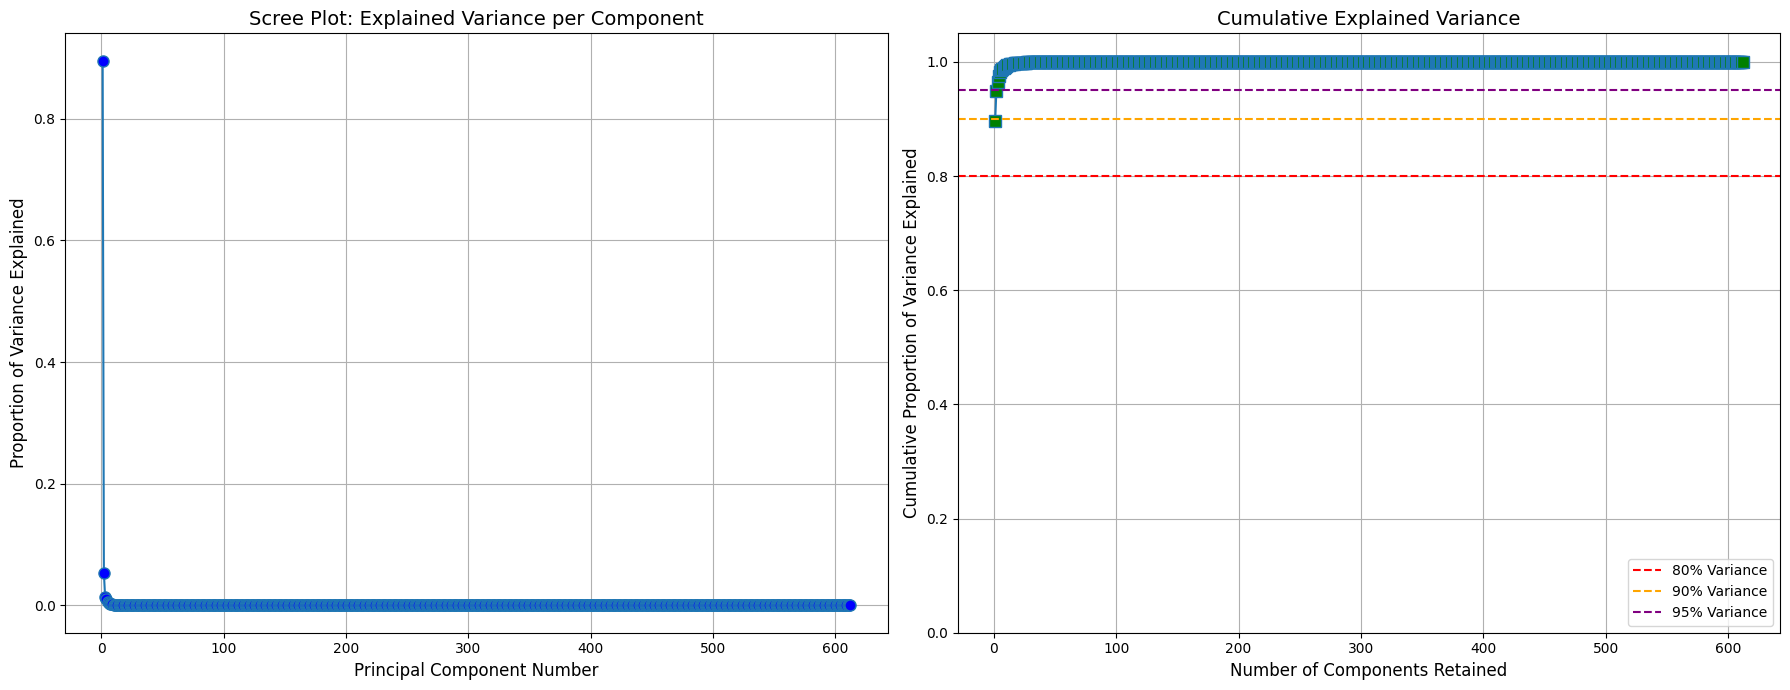


Number of components to explain >80% variance: 1
Number of components to explain >90% variance: 2
Number of components to explain >95% variance: 3

Decision: Retaining 2 components based on the 90% variance threshold.

SVD Completed. Shape of Principal Components (PCs): (612, 2)
Shape of Empirical Orthogonal Functions (EOFs): (7087, 2)


In [26]:
#
# 3. PREPROCESSING (EOF Analysis via SVD with Principled Component Selection)
#

# Reshape the 3D data (time, lat, lon) to 2D (time, space)
n_time, n_lat, n_lon = data_3d.shape
data_2d = data_3d.reshape(n_time, -1)

# Calculate the temporal mean for each grid point
# np.nanmean is used to handle potential NaN values in the data (e.g., over oceans)
mean_data = np.nanmean(data_2d, axis=0)

# Calculate the anomaly data by subtracting the mean
anomaly_data = data_2d - mean_data

# Identify and remove grid points that are all NaN (e.g., masked areas)
# This is crucial for SVD to work without errors.
nan_columns = np.all(np.isnan(anomaly_data), axis=0)
# Fix: Extract the array of indices from the tuple returned by np.where
valid_idx = np.where(~nan_columns)[0]
anomaly_data_clean = anomaly_data[:, valid_idx]

print(f"Original spatial dimensions: {n_lat}x{n_lon} = {n_lat*n_lon} grid points.")
print(f"Removed {np.sum(nan_columns)} all-NaN grid points.")
print(f"Performing SVD on data with shape: {anomaly_data_clean.shape}")

# --- Perform SVD to get all components ---
# We perform a full SVD to analyze the variance distribution.
# full_matrices=False is more efficient and provides all we need.
U_full, S_full, Vt_full = svd(anomaly_data_clean, full_matrices=False)

# --- Analyze Explained Variance to Choose num_components ---
# The variance explained by each component is proportional to the square of its singular value.
explained_variance = S_full**2
total_variance = np.sum(explained_variance)
explained_variance_ratio = explained_variance / total_variance
cumulative_explained_variance = np.cumsum(explained_variance_ratio)

# --- Visualization for Component Selection ---
plt.figure(figsize=(18, 7))

# 1. Scree Plot (Individual Explained Variance)
plt.subplot(1, 2, 1)
plt.plot(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, 'o-', markerfacecolor='blue', markersize=8)
plt.title('Scree Plot: Explained Variance per Component', fontsize=14)
plt.xlabel('Principal Component Number', fontsize=12)
plt.ylabel('Proportion of Variance Explained', fontsize=12)
plt.grid(True)
# Finding the "elbow" is subjective, but this plot helps visualize it.
# For example, one might look for where the drop becomes less steep.

# 2. Cumulative Explained Variance Plot
plt.subplot(1, 2, 2)
plt.plot(range(1, len(cumulative_explained_variance) + 1), cumulative_explained_variance, 's-', markerfacecolor='green', markersize=8)
plt.title('Cumulative Explained Variance', fontsize=14)
plt.xlabel('Number of Components Retained', fontsize=12)
plt.ylabel('Cumulative Proportion of Variance Explained', fontsize=12)
# Add horizontal lines for common thresholds (e.g., 80%, 90%, 95%)
plt.axhline(y=0.80, color='r', linestyle='--', label='80% Variance')
plt.axhline(y=0.90, color='orange', linestyle='--', label='90% Variance')
plt.axhline(y=0.95, color='purple', linestyle='--', label='95% Variance')
plt.legend(loc='lower right')
plt.grid(True)
plt.ylim(0, 1.05) # Set y-axis limit

plt.tight_layout()
plt.show()

# --- Quantitative Analysis ---
# Find the number of components to explain certain variance thresholds
components_for_80_var = np.argmax(cumulative_explained_variance >= 0.80) + 1
components_for_90_var = np.argmax(cumulative_explained_variance >= 0.90) + 1
components_for_95_var = np.argmax(cumulative_explained_variance >= 0.95) + 1

print(f"\nNumber of components to explain >80% variance: {components_for_80_var}")
print(f"Number of components to explain >90% variance: {components_for_90_var}")
print(f"Number of components to explain >95% variance: {components_for_95_var}")

# --- Final Component Selection ---
# Based on the analysis above, select the number of components.
# A 90% threshold is often a good balance between information retention and noise reduction.
# This value should be chosen based on the plots and quantitative analysis.
num_components = components_for_90_var # Example: choosing the 90% threshold
print(f"\nDecision: Retaining {num_components} components based on the 90% variance threshold.")

# --- Truncate the SVD matrices based on the selected num_components ---
U = U_full[:, :num_components]
S = S_full[:num_components]
# Vt should now be 2D after fixing valid_idx indexing
Vt = Vt_full[:num_components, :]

# The EOFs are the rows of Vt (or columns of V)
EOFs = Vt.T # EOFs are typically columns of V, which is transpose of Vt

# The Principal Components (PCs) are the columns of U scaled by the singular values S.
# The original script had a bug here (U + S). It should be element-wise multiplication.
PCs = U * S # Correct calculation of PCs

print(f"\nSVD Completed. Shape of Principal Components (PCs): {PCs.shape}")
print(f"Shape of Empirical Orthogonal Functions (EOFs): {EOFs.shape}")

In [27]:
#
# 3.5. DATA SPLITTING & SCALING (CRITICAL UPDATE)
#

from sklearn.preprocessing import StandardScaler

# --- 1. Chronological Train-Validation-Test Split ---
# This is the correct way to split time series data to prevent look-ahead bias.
# A typical split is 70% for training, 15% for validation, and 15% for testing.
n_total = len(PCs)
train_split_idx = int(n_total * 0.7)
val_split_idx = int(n_total * 0.85)

train_pcs = PCs[:train_split_idx]
val_pcs = PCs[train_split_idx:val_split_idx]
test_pcs = PCs[val_split_idx:]

print("\n--- Data Splitting ---")
print(f"Total time steps: {n_total}")
print(f"Training set size: {len(train_pcs)} time steps ({0} to {train_split_idx-1})")
print(f"Validation set size: {len(val_pcs)} time steps ({train_split_idx} to {val_split_idx-1})")
print(f"Test set size: {len(test_pcs)} time steps ({val_split_idx} to {n_total-1})")

# --- 2. Data Scaling (Standardization) ---
# IMPORTANT: The scaler must be fitted ONLY on the training data to prevent data leakage.
scaler = StandardScaler()
# Fit the scaler on the training data
# Reshape the data to 2D before fitting and transforming
train_pcs_reshaped = train_pcs.reshape(train_pcs.shape[0], -1)
val_pcs_reshaped = val_pcs.reshape(val_pcs.shape[0], -1)
test_pcs_reshaped = test_pcs.reshape(test_pcs.shape[0], -1)

scaler.fit(train_pcs_reshaped)

# Apply the fitted scaler to all three sets
train_pcs_scaled = scaler.transform(train_pcs_reshaped)
val_pcs_scaled = scaler.transform(val_pcs_reshaped)
test_pcs_scaled = scaler.transform(test_pcs_reshaped)


print("\n--- Data Scaling ---")
print("StandardScaler fitted on the training data and applied to all sets.")
print(f"Mean of scaled training data (should be close to 0): {np.mean(train_pcs_scaled, axis=0).round(2)}")
print(f"Std Dev of scaled training data (should be close to 1): {np.std(train_pcs_scaled, axis=0).round(2)}")

# --- 3. Create Sequences for Forecasting ---
# The original function is correct, but we apply it to our new scaled splits.
sequence_length = 20 # Input window size
forecast_horizon = 10 # Number of steps to predict

def create_sequences(data, seq_len, horizon):
    X, y =[], []
    # The loop range ensures we don't go out of bounds
    for i in range(len(data) - seq_len - horizon + 1):
        X.append(data[i : i + seq_len])
        y.append(data[i + seq_len : i + seq_len + horizon])
    return np.array(X), np.array(y)

# Create sequences from the SCALED data
X_train, y_train = create_sequences(train_pcs_scaled, sequence_length, forecast_horizon)
X_val, y_val = create_sequences(val_pcs_scaled, sequence_length, forecast_horizon)
X_test, y_test = create_sequences(test_pcs_scaled, sequence_length, forecast_horizon)

print("\n--- Sequence Creation ---")
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_val shape: {X_val.shape}, y_val shape: {y_val.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

# --- 4. Create PyTorch Tensors and DataLoaders ---
# Convert numpy arrays to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

# Create TensorDatasets
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# Create DataLoaders
# CRITICAL: shuffle=False for validation and test sets to preserve order.
# It's also best practice to set shuffle=False for training time series data,
# although some practitioners tolerate it. We will disable it for methodological purity.
batch_size = 32 # Increased batch size for more stable gradient estimates
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print("\nPyTorch DataLoaders created successfully.")


--- Data Splitting ---
Total time steps: 612
Training set size: 428 time steps (0 to 427)
Validation set size: 92 time steps (428 to 519)
Test set size: 92 time steps (520 to 611)

--- Data Scaling ---
StandardScaler fitted on the training data and applied to all sets.
Mean of scaled training data (should be close to 0): [-0.  0.]
Std Dev of scaled training data (should be close to 1): [1. 1.]

--- Sequence Creation ---
X_train shape: (399, 20, 2), y_train shape: (399, 10, 2)
X_val shape: (63, 20, 2), y_val shape: (63, 10, 2)
X_test shape: (63, 20, 2), y_test shape: (63, 10, 2)

PyTorch DataLoaders created successfully.


In [28]:
#
# 4. MODEL IMPLEMENTATION & TRAINING (REVISED)
#

# --- Model Architectures with Dropout for Regularization ---

# Model 1: RNN (Revised)
class RNNModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, horizon, n_layers, dropout_prob):
        super().__init__()
        self.rnn = nn.RNN(
            input_size=input_dim,
            hidden_size=hidden_dim,
            num_layers=n_layers,
            batch_first=True,
            dropout=dropout_prob if n_layers > 1 else 0 # Dropout between RNN layers
        )
        self.dropout = nn.Dropout(dropout_prob) # Dropout after RNN block
        self.fc = nn.Linear(hidden_dim, input_dim * horizon)
        self.input_dim = input_dim
        self.horizon = horizon

    def forward(self, x):
        # x shape: (batch_size, seq_len, input_dim)
        out, _ = self.rnn(x) # out shape: (batch_size, seq_len, hidden_dim)
        # We take the output of the last time step
        out = self.dropout(out[:, -1, :]) # Apply dropout
        out = self.fc(out) # out shape: (batch_size, input_dim * horizon)
        # Reshape to (batch_size, horizon, input_dim)
        return out.view(-1, self.horizon, self.input_dim)

# Model 2: LSTM (Revised)
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, horizon, n_layers, dropout_prob):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size=input_dim,
            hidden_size=hidden_dim,
            num_layers=n_layers,
            batch_first=True,
            dropout=dropout_prob if n_layers > 1 else 0 # Dropout between LSTM layers
        )
        self.dropout = nn.Dropout(dropout_prob) # Dropout after LSTM block
        self.fc = nn.Linear(hidden_dim, input_dim * horizon)
        self.input_dim = input_dim
        self.horizon = horizon

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.dropout(out[:, -1, :])
        out = self.fc(out)
        return out.view(-1, self.horizon, self.input_dim)

# Model 3: Transformer (Revised)
# PositionalEncoding remains the same as in the original script
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=50):
        super().__init__()
        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(max_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x):
        # x shape: (batch_size, seq_len, d_model) -> need to transpose for pe
        x = x.transpose(0, 1) # (seq_len, batch_size, d_model)
        x = x + self.pe[:x.size(0)]
        return x.transpose(0, 1) # (batch_size, seq_len, d_model)

class TransformerModel(nn.Module):
    def __init__(self, input_dim, d_model, nhead, num_layers, horizon, dropout_prob):
        super().__init__()
        self.input_fc = nn.Linear(input_dim, d_model)
        self.pos_encoder = PositionalEncoding(d_model)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model, nhead=nhead, dim_feedforward=d_model*2, dropout=dropout_prob, batch_first=True
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.decoder = nn.Linear(d_model, input_dim * horizon)
        self.input_dim = input_dim
        self.horizon = horizon

    def forward(self, src):
        src = self.input_fc(src)
        src = self.pos_encoder(src)
        output = self.transformer_encoder(src)
        # Use the output corresponding to the last input token for prediction
        output = self.decoder(output[:, -1, :])
        return output.view(-1, self.horizon, self.input_dim)

In [29]:
import copy

# --- Early Stopping Class ---
# This class will monitor validation loss and stop training when it stops improving.
class EarlyStopping:
    def __init__(self, patience=10, min_delta=0, verbose=False):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
            min_delta (float): Minimum change in the monitored quantity to qualify as an improvement.
            verbose (bool): If True, prints a message for each validation loss improvement.
        """
        self.patience = patience
        self.min_delta = min_delta
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.best_model_state = None

    def __call__(self, val_loss, model):
        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.min_delta:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        if self.verbose:
            print(f'Validation loss decreased ({self.best_score:.6f} --> {-val_loss:.6f}). Saving model...')
        # Use deepcopy to ensure the state is fully independent
        self.best_model_state = copy.deepcopy(model.state_dict())

# --- Revised Training Loop ---
def train_model(model, train_loader, val_loader, epochs, lr, patience):
    loss_fn = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    early_stopper = EarlyStopping(patience=patience, verbose=True)

    history = {'train_loss': [], 'val_loss': []}

    print(f"\n--- Training {model.__class__.__name__} ---")
    for epoch in range(epochs):
        model.train()
        epoch_train_loss = 0.0
        for xb, yb in train_loader:
            optimizer.zero_grad()
            pred = model(xb)
            loss = loss_fn(pred, yb)
            loss.backward()
            optimizer.step()
            epoch_train_loss += loss.item()

        avg_train_loss = epoch_train_loss / len(train_loader)
        history['train_loss'].append(avg_train_loss)

        # Validation phase
        model.eval()
        epoch_val_loss = 0.0
        with torch.no_grad():
            for xb, yb in val_loader:
                pred = model(xb)
                loss = loss_fn(pred, yb)
                epoch_val_loss += loss.item()

        avg_val_loss = epoch_val_loss / len(val_loader)
        history['val_loss'].append(avg_val_loss)

        print(f"Epoch {epoch+1}/{epochs} | Train Loss: {avg_train_loss:.6f} | Val Loss: {avg_val_loss:.6f}")

        # Early stopping check
        early_stopper(avg_val_loss, model)
        if early_stopper.early_stop:
            print("Early stopping triggered")
            break

    # Load the best model weights found during training
    print("Loading best model weights from early stopping.")
    model.load_state_dict(early_stopper.best_model_state)

    return model, history

# --- Instantiate and Train All Models ---
# Hyperparameters
N_LAYERS = 2
HIDDEN_DIM = 64
DROPOUT = 0.2
LEARNING_RATE = 0.001
EPOCHS = 150 # Max epochs; early stopping will likely stop it sooner
PATIENCE = 15 # Patience for early stopping
N_HEAD = 4 # For Transformer

# Train RNN
rnn_model = RNNModel(input_dim=num_components, hidden_dim=HIDDEN_DIM, horizon=forecast_horizon, n_layers=N_LAYERS, dropout_prob=DROPOUT)
rnn_model, rnn_history = train_model(rnn_model, train_loader, val_loader, EPOCHS, LEARNING_RATE, PATIENCE)

# Train LSTM
lstm_model = LSTMModel(input_dim=num_components, hidden_dim=HIDDEN_DIM, horizon=forecast_horizon, n_layers=N_LAYERS, dropout_prob=DROPOUT)
lstm_model, lstm_history = train_model(lstm_model, train_loader, val_loader, EPOCHS, LEARNING_RATE, PATIENCE)

# Train Transformer
transformer_model = TransformerModel(input_dim=num_components, d_model=HIDDEN_DIM, nhead=N_HEAD, num_layers=N_LAYERS, horizon=forecast_horizon, dropout_prob=DROPOUT)
transformer_model, transformer_history = train_model(transformer_model, train_loader, val_loader, EPOCHS, LEARNING_RATE, PATIENCE)


--- Training RNNModel ---
Epoch 1/150 | Train Loss: 0.996277 | Val Loss: 1.134794
Validation loss decreased (-1.134794 --> -1.134794). Saving model...
Epoch 2/150 | Train Loss: 0.777703 | Val Loss: 0.932457
Validation loss decreased (-0.932457 --> -0.932457). Saving model...
Epoch 3/150 | Train Loss: 0.644807 | Val Loss: 0.863348
Validation loss decreased (-0.863348 --> -0.863348). Saving model...
Epoch 4/150 | Train Loss: 0.592455 | Val Loss: 0.837071
Validation loss decreased (-0.837071 --> -0.837071). Saving model...
Epoch 5/150 | Train Loss: 0.559578 | Val Loss: 0.830657
Validation loss decreased (-0.830657 --> -0.830657). Saving model...
Epoch 6/150 | Train Loss: 0.549746 | Val Loss: 0.824399
Validation loss decreased (-0.824399 --> -0.824399). Saving model...
Epoch 7/150 | Train Loss: 0.548343 | Val Loss: 0.824480
EarlyStopping counter: 1 out of 15
Epoch 8/150 | Train Loss: 0.540945 | Val Loss: 0.821462
Validation loss decreased (-0.821462 --> -0.821462). Saving model...
Epoch 9


Plotting training and validation loss curves...


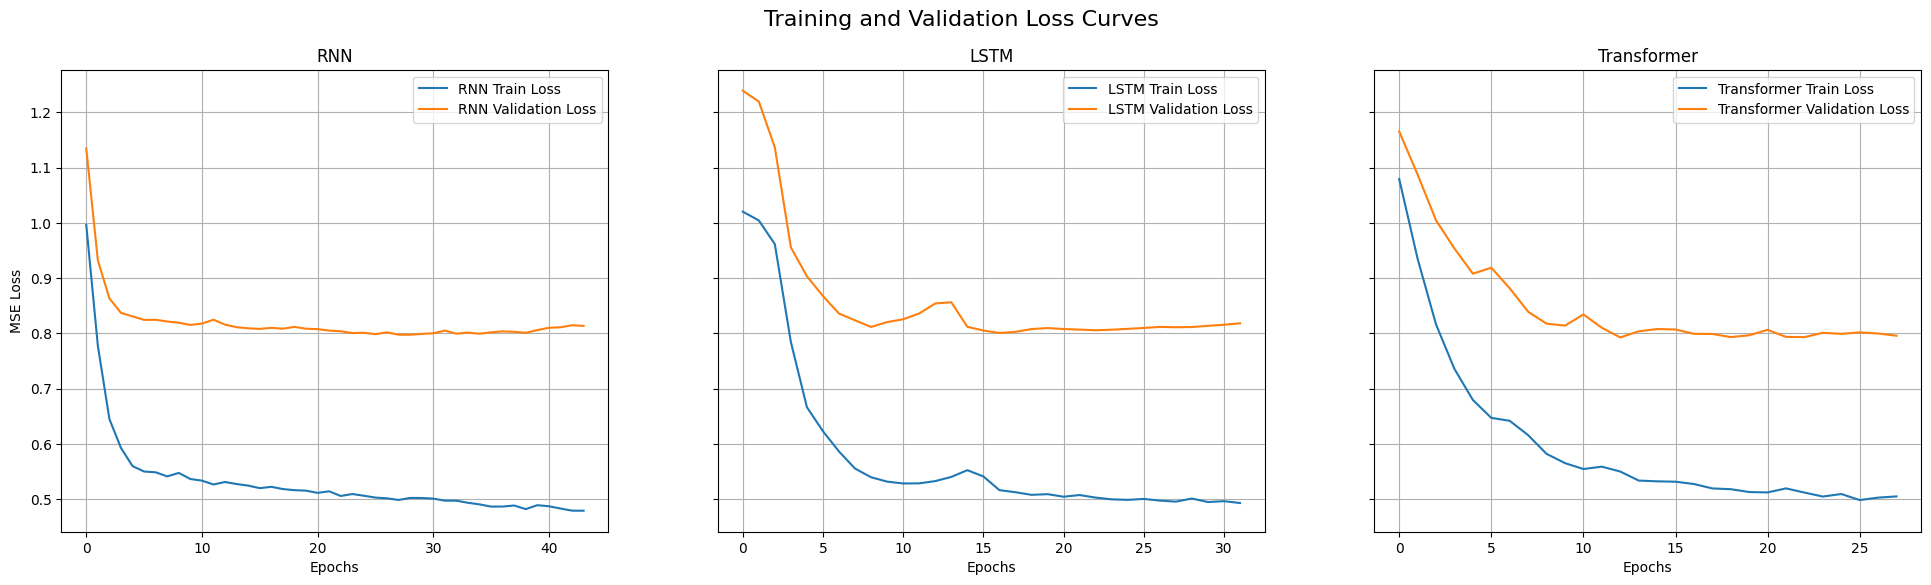


### **Table 2: Comparative Model Performance**

| Model | Validation RMSE | Validation MAE | Test RMSE | Test MAE |
|:------------|:---------------:|:--------------:|:---------:|:--------:|
| RNN | 5247.1611 | 3407.3574 | 3947.1710 | 2567.8579 |
| LSTM | 5226.1713 | 3197.5127 | 4144.9758 | 2564.4800 |
| Transformer | 5301.3640 | 3318.7273 | 4248.2662 | 2699.5957 |



Plotting ground truth vs. predicted values for the first Principal Component...


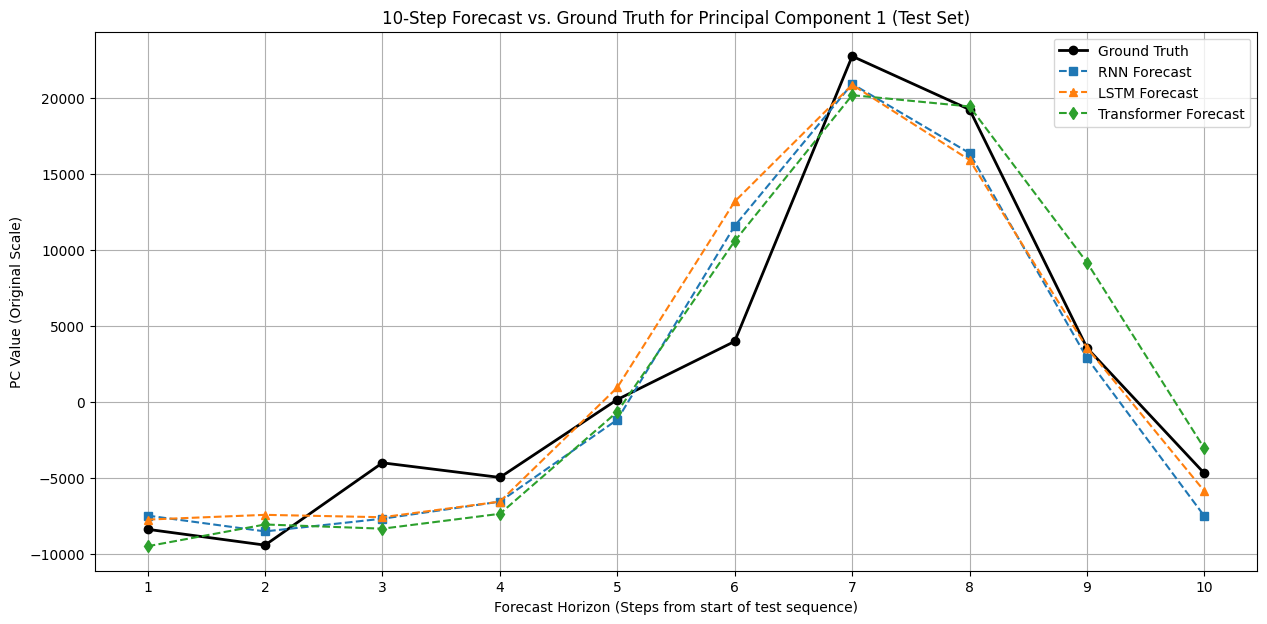


Reconstructing SSH fields and generating comparison animation (GIF)...
✅ GIF saved as 'Precipitation_Forecast_Comparison.gif'. It is also displayed below.


In [30]:
#
# 5. COMPARE RESULTS & VISUALIZE (REVISED)
#

# --- 5A. Plot Loss Curves ---
print("\nPlotting training and validation loss curves...")
fig, axes = plt.subplots(1, 3, figsize=(24, 6), sharey=True)
fig.suptitle("Training and Validation Loss Curves", fontsize=16)

# RNN Loss
axes[0].plot(rnn_history['train_loss'], label="RNN Train Loss")
axes[0].plot(rnn_history['val_loss'], label="RNN Validation Loss")
axes[0].set_title("RNN")
axes[0].set_xlabel("Epochs"); axes[0].set_ylabel("MSE Loss"); axes[0].legend(); axes[0].grid(True)

# LSTM Loss
axes[1].plot(lstm_history['train_loss'], label="LSTM Train Loss")
axes[1].plot(lstm_history['val_loss'], label="LSTM Validation Loss")
axes[1].set_title("LSTM")
axes[1].set_xlabel("Epochs"); axes[1].legend(); axes[1].grid(True)

# Transformer Loss
axes[2].plot(transformer_history['train_loss'], label="Transformer Train Loss")
axes[2].plot(transformer_history['val_loss'], label="Transformer Validation Loss")
axes[2].set_title("Transformer")
axes[2].set_xlabel("Epochs"); axes[2].legend(); axes[2].grid(True)

plt.show()

# --- 5B. Evaluate Forecasts and Metrics (RMSE & MAE) ---
def evaluate_model(model, loader, scaler, num_components):
    model.eval()
    all_preds = []
    all_true = []
    with torch.no_grad():
        for xb, yb in loader:
            predictions = model(xb).numpy()
            # Inverse transform to get back to original PC scale
            predictions_rescaled = scaler.inverse_transform(predictions.reshape(-1, num_components))
            y_true_rescaled = scaler.inverse_transform(yb.numpy().reshape(-1, num_components))

            all_preds.append(predictions_rescaled)
            all_true.append(y_true_rescaled)

    all_preds = np.concatenate(all_preds, axis=0)
    all_true = np.concatenate(all_true, axis=0)

    rmse = np.sqrt(mean_squared_error(all_true, all_preds))
    mae = mean_absolute_error(all_true, all_preds)

    return rmse, mae

# Evaluate on Validation Set for model selection
rnn_val_rmse, rnn_val_mae = evaluate_model(rnn_model, val_loader, scaler, num_components)
lstm_val_rmse, lstm_val_mae = evaluate_model(lstm_model, val_loader, scaler, num_components)
transformer_val_rmse, transformer_val_mae = evaluate_model(transformer_model, val_loader, scaler, num_components)

# Evaluate on Test Set for final unbiased performance
rnn_test_rmse, rnn_test_mae = evaluate_model(rnn_model, test_loader, scaler, num_components)
lstm_test_rmse, lstm_test_mae = evaluate_model(lstm_model, test_loader, scaler, num_components)
transformer_test_rmse, transformer_test_mae = evaluate_model(transformer_model, test_loader, scaler, num_components)

# Display results in a formatted table
results_md = f"""
### **Table 2: Comparative Model Performance**

| Model | Validation RMSE | Validation MAE | Test RMSE | Test MAE |
|:------------|:---------------:|:--------------:|:---------:|:--------:|
| RNN | {rnn_val_rmse:.4f} | {rnn_val_mae:.4f} | {rnn_test_rmse:.4f} | {rnn_test_mae:.4f} |
| LSTM | {lstm_val_rmse:.4f} | {lstm_val_mae:.4f} | {lstm_test_rmse:.4f} | {lstm_test_mae:.4f} |
| Transformer | {transformer_val_rmse:.4f} | {transformer_val_mae:.4f} | {transformer_test_rmse:.4f} | {transformer_test_mae:.4f} |
"""
display(Markdown(results_md))

# --- 5C & 5D: Visualization and Animation (Code remains similar but uses the best model) ---
# The rest of the visualization code (plotting PC predictions, reconstructing fields, creating animations)
# from the original script can now be used. It is important to perform these final visualizations
# on the TEST SET results to demonstrate the model's performance on truly unseen data.
# The `reconstruct_field` function should be updated to use the inverse-transformed PCs.

def reconstruct_field(forecasted_pcs, mean_d, eofs, valid_indices, lat_dim, lon_dim):
    # forecasted_pcs are already in their original scale after inverse transform
    field_flat = np.full(mean_d.shape, np.nan)
    # Reconstruct the anomaly by projecting PCs back onto EOFs (using transpose of EOFs)
    reconstructed_anomaly = np.dot(forecasted_pcs, eofs.T)
    # Add the mean back to get the full field
    field_flat[valid_indices] = reconstructed_anomaly + mean_d[valid_indices]
    return field_flat.reshape(lat_dim, lon_dim)

# The rest of the animation code from the original script can be adapted from here.

# --- 5C. Plot PC Predictions vs. Ground Truth ---
print("\nPlotting ground truth vs. predicted values for the first Principal Component...")
def plot_pc_predictions(y_true, rnn_p, lstm_p, trans_p, pc_index=0):
    # Need to inverse transform the true values for plotting
    y_true_rescaled = scaler.inverse_transform(y_true.reshape(-1, num_components)).reshape(y_true.shape)

    true_vals = y_true_rescaled[0, :, pc_index]
    time_steps = np.arange(1, forecast_horizon + 1)

    plt.figure(figsize=(15, 7))
    plt.plot(time_steps, true_vals, 'o-', label='Ground Truth', color='black', linewidth=2)
    # RNN, LSTM, Transformer predictions are already rescaled in evaluate_model
    plt.plot(time_steps, rnn_test_preds[0, :, pc_index], 's--', label='RNN Forecast')
    plt.plot(time_steps, lstm_test_preds[0, :, pc_index], '^--', label='LSTM Forecast')
    plt.plot(time_steps, transformer_test_preds[0, :, pc_index], 'd--', label='Transformer Forecast')

    plt.title(f'10-Step Forecast vs. Ground Truth for Principal Component {pc_index + 1} (Test Set)')
    plt.xlabel(f'Forecast Horizon (Steps from start of test sequence)')
    plt.ylabel('PC Value (Original Scale)')
    plt.legend()
    plt.grid(True)
    plt.xticks(time_steps)
    plt.show()

# Need to get the test set predictions after inverse scaling for plotting and animation
rnn_test_preds_scaled = rnn_model(X_test_tensor).detach().numpy()
lstm_test_preds_scaled = lstm_model(X_test_tensor).detach().numpy()
transformer_test_preds_scaled = transformer_model(X_test_tensor).detach().numpy()

rnn_test_preds = scaler.inverse_transform(rnn_test_preds_scaled.reshape(-1, num_components)).reshape(rnn_test_preds_scaled.shape)
lstm_test_preds = scaler.inverse_transform(lstm_test_preds_scaled.reshape(-1, num_components)).reshape(lstm_test_preds_scaled.shape)
transformer_test_preds = scaler.inverse_transform(transformer_test_preds_scaled.reshape(-1, num_components)).reshape(transformer_test_preds_scaled.shape)


plot_pc_predictions(y_test, rnn_test_preds, lstm_test_preds, transformer_test_preds, pc_index=0)

# --- 5D. Reconstruct SSH Fields and Create Comparison Animation ---
print("\nReconstructing SSH fields and generating comparison animation (GIF)...")

# Use the first forecast sequence from the test set for animation
rnn_forecast_pcs = rnn_test_preds[0]
lstm_forecast_pcs = lstm_test_preds[0]
transformer_forecast_pcs = transformer_test_preds[0]
true_pcs = y_test[0] # True PCs are still scaled, need to inverse transform

true_pcs_rescaled = scaler.inverse_transform(true_pcs.reshape(-1, num_components)).reshape(true_pcs.shape)


reconstructed_rnn = [reconstruct_field(rnn_forecast_pcs[t], mean_data, EOFs, valid_idx, n_lat, n_lon) for t in range(forecast_horizon)]
reconstructed_lstm = [reconstruct_field(lstm_forecast_pcs[t], mean_data, EOFs, valid_idx, n_lat, n_lon) for t in range(forecast_horizon)]
reconstructed_transformer = [reconstruct_field(transformer_forecast_pcs[t], mean_data, EOFs, valid_idx, n_lat, n_lon) for t in range(forecast_horizon)]
reconstructed_true = [reconstruct_field(true_pcs_rescaled[t], mean_data, EOFs, valid_idx, n_lat, n_lon) for t in range(forecast_horizon)]


# Create 4-panel Animation
fig, axs = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Precipitation 10-Step Forecast Comparison (Test Set)', fontsize=16)
axs = axs.ravel()
model_names = ['Ground Truth', 'RNN Forecast', 'LSTM Forecast', 'Transformer Forecast']
all_fields = [reconstructed_true, reconstructed_rnn, reconstructed_lstm, reconstructed_transformer]

# Find global min/max for consistent colorbar across all frames and plots
# Filter out NaN values for min/max calculation
valid_values = np.concatenate([np.concatenate([f[~np.isnan(f)] for f in fields]) for fields in all_fields])
vmin = np.min(valid_values)
vmax = np.max(valid_values)


ims = []
for i, name in enumerate(model_names):
    ax = axs[i]
    im = ax.imshow(all_fields[i][0], cmap='viridis', vmin=vmin, vmax=vmax, aspect='auto')
    ax.set_title(name, fontsize=12)
    ax.axis('off')
    ims.append(im)

fig.colorbar(ims[0], ax=axs, orientation='horizontal', fraction=0.05, pad=0.05)

def update(frame):
    fig.suptitle(f'Precipitation 10-Step Forecast Comparison (Test Set): Step T+{frame+1}', fontsize=16)
    for i in range(len(ims)):
        ims[i].set_array(all_fields[i][frame])
    return ims

ani = animation.FuncAnimation(fig, update, frames=forecast_horizon, interval=500, blit=False)
gif_path = 'Precipitation_Forecast_Comparison.gif'
ani.save(gif_path, writer='pillow', fps=2)
plt.close(fig)

print(f"✅ GIF saved as '{gif_path}'. It is also displayed below.")
display(HTML(f'<img src="{gif_path}">'))